In [22]:
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal
from pyro.infer import SVI
from pyro.optim import Adam

from matplotlib import pyplot
%matplotlib inline

In [15]:
N = 100  # size of toy data
p = 1    # number of features

def build_linear_dataset(N, noise_std=0.1):
    X = np.linspace(-6, 6, num=N)
    y = 3 * X + 1 + np.random.normal(0, noise_std, size=N)
    X, y = X.reshape((N, 1)), y.reshape((N, 1))
    X, y = Variable(torch.Tensor(X)), Variable(torch.Tensor(y))
    return torch.cat((X, y), 1)


In [16]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)

    def forward(self, x):
        return self.linear(x)

regression_model = RegressionModel(p)

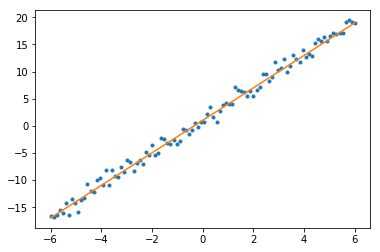

In [108]:
loss_fn = torch.nn.MSELoss(size_average=False)
optim = torch.optim.Adam(regression_model.parameters(), lr=0.01)
num_iterations = 1000

data = build_linear_dataset(N, p)
x_data = data[:, :-1]
y_data = data[:, -1]

pyplot.plot(x_data.data.numpy(), y_data.data.numpy(), '.')
pyplot.plot(x_data.data.numpy(), regression_model(x_data).data.numpy())

[iteration 0050] loss: 88.4151
[iteration 0100] loss: 88.4143
[iteration 0150] loss: 88.4143
[iteration 0200] loss: 88.4143
[iteration 0250] loss: 88.4143
[iteration 0300] loss: 88.4143
[iteration 0350] loss: 88.4143
[iteration 0400] loss: 88.4143
[iteration 0450] loss: 88.4143
[iteration 0500] loss: 88.4143
[iteration 0550] loss: 88.4143
[iteration 0600] loss: 88.4143
[iteration 0650] loss: 88.4143
[iteration 0700] loss: 88.4143
[iteration 0750] loss: 88.4143
[iteration 0800] loss: 88.4143
[iteration 0850] loss: 88.4143
[iteration 0900] loss: 88.4143
[iteration 0950] loss: 88.4143
[iteration 1000] loss: 88.4143
Learned parameters:
linear.weight: 3.018
linear.bias: 1.185


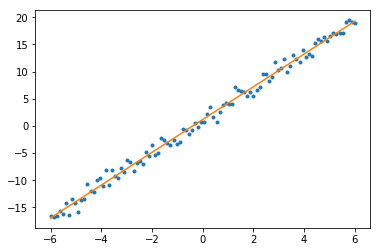

In [109]:
for j in range(num_iterations):
    # run the model forward on the data
    y_pred = regression_model(x_data)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.data[0]))
# Inspect learned parameters
print("Learned parameters:")
for name, param in regression_model.named_parameters():
    print("%s: %.3f" % (name, param.data.numpy()))

pyplot.plot(x_data.data.numpy(), y_data.data.numpy(), '.')
pyplot.plot(x_data.data.numpy(), regression_model(x_data).data.numpy())


In [50]:
mu = Variable(torch.zeros(1, 1))
sigma = Variable(torch.ones(1, 1))
# define a unit normal prior
prior = Normal(mu, sigma)
# overload the parameters in the regression module with samples from the prior
lifted_module = pyro.random_module("regression_module", regression_model, prior)
# sample a regressor from the prior
sampled_reg_model = lifted_module()



In [47]:
def model(data):
    # Create unit normal priors over the parameters
    x_data = data[:, :-1]
    y_data = data[:, -1]
    mu, sigma = Variable(torch.zeros(p, 1)), Variable(10 * torch.ones(p, 1))
    bias_mu, bias_sigma = Variable(torch.zeros(1)), Variable(10 * torch.ones(1))
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    # run the regressor forward conditioned on data
    prediction_mean = lifted_reg_model(x_data).squeeze()
    # condition on the observed data
    pyro.observe("obs", Normal(prediction_mean, Variable(0.1 * torch.ones(data.size(0)))),
                 y_data.squeeze())


In [7]:
softplus = torch.nn.Softplus()

def guide(data):
    # define our variational parameters
    w_mu = Variable(torch.randn(p, 1), requires_grad=True)
    # note that we initialize our sigmas to be pretty narrow
    w_log_sig = Variable(-3.0 * torch.ones(p, 1) + 0.05 * torch.randn(p, 1),
                         requires_grad=True)
    b_mu = Variable(torch.randn(1), requires_grad=True)
    b_log_sig = Variable(-3.0 * torch.ones(1) + 0.05 * torch.randn(1),
                         requires_grad=True)
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    # guide distributions for w and b
    w_dist, b_dist = Normal(mw_param, sw_param), Normal(mb_param, sb_param)
    dists = {'linear.weight': w_dist, 'linear.bias': b_dist}
    # overload the parameters in the module with random samples
    # from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor (which also samples w and b)
    return lifted_module()

RegressionModel(
  (linear): Linear(in_features=1, out_features=1)
)

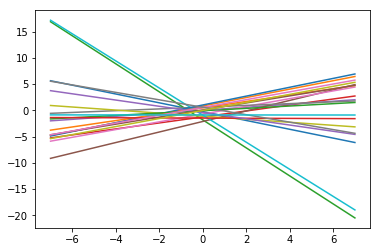

In [107]:

X = np.linspace(-7, 7, num=20)
y = 3 * X + 1
X, y = X.reshape((20, 1)), y.reshape((20, 1))
x_data, y_data = Variable(torch.Tensor(X)), Variable(torch.Tensor(y))
y_preds = []
for i in range(20):
    pyro.clear_param_store()
    # guide does not require the data
    sampled_reg_model = guide(None)
    # run the regression model and add prediction to total
    y_preds.append(sampled_reg_model(x_data)) # not so good because we are keeping the trace...

y_preds = torch.stack(y_preds,0)

# take the average of the predictions
mean_y_preds = y_preds.mean(0)

pyplot.plot(X[:,0], y_preds.data.squeeze().numpy().T)
#pyplot.plot(X[:,0], y,'o')
sampled_reg_model

In [8]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss="ELBO")


In [110]:
pyro.clear_param_store()
data = build_linear_dataset(N, p)
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / float(N)))


[iteration 0001] loss: 7628.7406
[iteration 0101] loss: 4058.9150
[iteration 0201] loss: 2090.8386
[iteration 0301] loss: 949.2296
[iteration 0401] loss: 357.0384
[iteration 0501] loss: 203.5179
[iteration 0601] loss: 106.4129
[iteration 0701] loss: 57.5109
[iteration 0801] loss: 48.0589
[iteration 0901] loss: 51.4549


In [111]:
for name in pyro.get_param_store().get_all_param_names():
    print("[%s]: %.3f" % (name, pyro.param(name).data.numpy()))



[guide_log_sigma_weight]: -3.104
[guide_mean_weight]: 2.994
[guide_log_sigma_bias]: -4.118
[guide_mean_bias]: 0.952


Loss:  0.014409460127353668


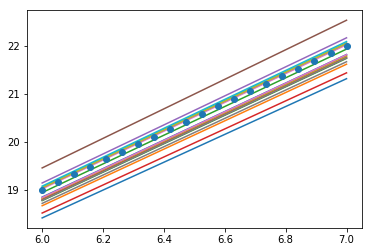

In [113]:
X = np.linspace(6, 7, num=20)
y = 3 * X + 1
X, y = X.reshape((20, 1)), y.reshape((20, 1))
x_data, y_data = Variable(torch.Tensor(X)), Variable(torch.Tensor(y))
loss = nn.MSELoss()
y_preds = []
for i in range(20):
    # guide does not require the data
    sampled_reg_model = guide(None)
    # run the regression model and add prediction to total
    y_preds.append(sampled_reg_model(x_data)) # not so good because we are keeping the trace...

y_preds = torch.stack(y_preds,0)

# take the average of the predictions
mean_y_preds = y_preds.mean(0)
print ("Loss: ", loss(mean_y_preds, y_data).data[0])

pyplot.plot(X[:,0], y_preds.data.squeeze().numpy().T)
pyplot.plot(X[:,0], y,'o')

In [39]:
?? pyro.poutine.lift

In [93]:
ps = pyro.get_param_store()
ps.get_all_param_names()

dict_keys(['guide_log_sigma_weight', 'guide_mean_weight', 'guide_log_sigma_bias', 'guide_mean_bias'])

In [115]:
a = torch.Tensor([1])

In [116]:
a.cpu()


 1
[torch.FloatTensor of size 1]